In [2]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

from chainercv.visualizations import vis_bbox
from chainercv.utils import bbox_iou, non_maximum_suppression
import chainer
import chainer.links as L
import chainer.functions as F
import numpy as np
import imageio
import json
import pandas as pd
import tables
from chainer.dataset.convert import concat_examples

%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('script/training/')

from train import get_dataset, setup_model

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [3]:
from collections import defaultdict

class GroundingDataPbd(chainer.dataset.DatasetMixin):
    def __init__(self, gt_roi_file, roi_file, region_feat_file, phrase_feature_file, unique_phrase_file):
        # setup phrase feature provider
        phrase2id_dict = defaultdict(lambda: -1)
        with open(unique_phrase_file) as f:
            for i, line in enumerate(f):
                phrase2id_dict[line.rstrip()] = i
        
        self._p2i_dict = phrase2id_dict
        self._feat = np.load(phrase_feature_file).astype(np.float32)
        
        df = pd.read_csv(gt_roi_file)
        df_drop = df.drop_duplicates(['image', 'org_phrase']) # remove duplicate
        
        self._gt_roi_df = df
        self._phrase = df_drop.phrase.values
        self._image_ids = df_drop.image.values
        
#         self._gt_roi = np.asarray(df[['xmin', 'ymin', 'xmax', 'ymax']], dtype=np.float32)
        
        # setup region feature provider
        self._roi_feat_file = tables.open_file(region_feat_file)
        
        # setup roi coord provider
        self._roi_coord_file = tables.open_file(roi_file)
    
    def __len__(self):
        return len(self._phrase)
    def _get_entity(self, i):
        x = self._feat[self._p2i_dict[self._phrase[i]]]
        return x
    
    def _get_roi(self, i):
        return self._roi_coord_file.get_node('/', str(self._image_ids[i])).read()
    
    def _get_roi_feat(self, i):
        return self._roi_feat_file.get_node('/', str(self._image_ids[i])).read()
    
    def _get_gt_roi(self, i):
        img_id = self._image_ids[i]
        phrase = self._phrase[i]
        gt_roi = self._gt_roi_df[(self._gt_roi_df.image == img_id) & (self._gt_roi_df.phrase == phrase)][['xmin', 'ymin', 'xmax', 'ymax']]
        gt_roi_min = gt_roi.min(axis=0)
        gt_roi_max = gt_roi.max(axis=0)
        return np.hstack((gt_roi_min[:2], gt_roi_max[-2:]))
        
    def get_example(self, i):
        x = self._get_roi_feat(i)
        y = self._get_entity(i)
        roi = self._get_roi(i)
        gt_roi = self._get_gt_roi(i)
        return y, x, roi, gt_roi

In [5]:
mode = 'gtp'
model = setup_model(mode)
chainer.serializers.load_npz('best_models/frcnn_pca+wea-gtp_20180304-220918/model', model)

In [12]:
in_vtype = 'frcnn_pca'
in_ttype = 'wea'
dataset = GroundingDataPbd('data/gt_roi_cord_test.csv',
                 'data/region_feat/cca/roi_test.h5',
                 'data/region_feat/%s/test.h5'%in_vtype,
                'data/phrase_feat/%s/test.npy'%in_ttype,
                'data/phrase_misc/test_uniquePhrases')

In [19]:
np.save('best_models/frcnn_pca+wea-gtp_20180304-220918/attention_mat', M_att)

In [15]:
def compute_rank(pred_roi, score, gt_roi):
    res = []
    for pred_bbox, s, gt_bbox in zip(pred_roi, score, gt_roi):
        # non maximum supression
        roi_ = pred_bbox[:,[1,0,3,2]]
        gt_roi_ = gt_bbox[[1,0,3,2]]

        roi_indices = non_maximum_suppression(roi_, thresh=.5, score=s)

        # compute rank
        ious = bbox_iou(roi_[roi_indices], gt_roi_[None, :])
        ranks, = np.where(ious.ravel() > .5)
        best_rank = ranks.min() if ranks.size else np.nan
        res.append(best_rank)
    return res
        
def evaluation_test(model, dataset, b_size, device=None):
    N = len(dataset)
    pred_bbox = np.zeros((N, 4))
    gt_bbox = np.zeros((N, 4))
    M_att = np.zeros((N, 200))
    
    R = []
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        for i in range(0, N, b_size):
            phr, roi_feat, roi, gt_roi = concat_examples(dataset[i:i+b_size])
            
            if device is not None:
                phr = chainer.cuda.to_gpu(phr)
                roi_feat = chainer.cuda.to_gpu(roi_feat)
            
            att, _ = model.attention_net(phr, roi_feat)
            att.to_cpu()
            att = att.data
            M_att[i:i+b_size] = att
            
            ranks = compute_rank(roi, att, gt_roi)
            R += ranks
            print('%i / %i'%(i+b_size, N))
            
        return R, M_att

chainer.cuda.get_device_from_id(0).use()
model.to_gpu()
res, M_att = evaluation_test(model, dataset, 800, device=0)

800 / 11560
1600 / 11560
2400 / 11560
3200 / 11560
4000 / 11560
4800 / 11560
5600 / 11560
6400 / 11560
7200 / 11560
8000 / 11560
8800 / 11560
9600 / 11560
10400 / 11560
11200 / 11560
12000 / 11560


In [16]:
res_arr = np.array(res)

r1 = (res_arr < 1).sum() / res_arr.size
r5 = (res_arr < 5).sum() / res_arr.size
r10 = (res_arr < 10).sum() / res_arr.size
print('R@1 %.2f, R@5 %.2f, R@10 %.2f' %(r1*100, r5*100, r10*100))

R@1 41.84, R@5 60.95, R@10 65.61


/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


array([[1.25040609e-08, 3.75143117e-08, 4.96400290e-08, ...,
        9.46906141e-07, 4.08571594e-08, 4.83521217e-05],
       [8.28517521e-09, 9.06892978e-07, 2.58087266e-06, ...,
        2.42833394e-05, 4.20185700e-08, 6.82720623e-04],
       [2.44389144e-13, 1.36033042e-11, 4.30597120e-11, ...,
        6.13617033e-08, 1.81634718e-09, 1.78315531e-05],
       ...,
       [6.69057454e-06, 1.13973693e-08, 9.04575304e-10, ...,
        2.37837550e-03, 1.29596852e-02, 6.56382460e-03],
       [1.04839215e-04, 9.89172713e-06, 4.43578847e-06, ...,
        1.14540057e-03, 1.14763714e-03, 3.55627993e-03],
       [8.43689207e-09, 6.10750135e-07, 7.88142984e-07, ...,
        2.03043128e-05, 2.79390434e-07, 1.49154875e-08]])

In [ ]:
pred_ = pred[:,[1,0,3,2]]
gt_ = gt[:,[1,0,3,2]]

In [53]:
ious = bbox_iou(pred_, gt_)

In [58]:
np.mean(ious.diagonal())

0.4114741275043413

several+climbers


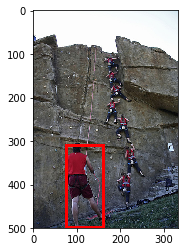

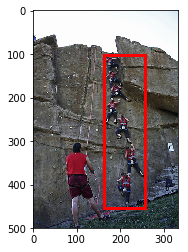

In [57]:
i = 0#np.random.randint(len(pred))
img_id = dataset._image_ids[i]
phrase = dataset._phrase[i]
im = plt.imread('/home/mayu-ot/durga/Dataset/Flickr30kEntities/flickr30k-images/%i.jpg' % img_id)

print(phrase)
pred_ = pred[:,[1,0,3,2]]
vis_bbox(im.transpose(2, 0, 1), pred_[None, i])

gt_ = gt[:,[1,0,3,2]]
vis_bbox(im.transpose(2, 0, 1), gt_[None, i])

In [19]:
gt

array([[162., 102., 256., 454.],
       [  1.,  54., 333., 500.],
       [ 74., 302., 181., 500.],
       ...,
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.]])